## Резюме:

Была поставлена задача построить модель для оценки кредитного риска — предсказание выхода клиента в дефолт по кредиту,
то есть задача бинарной классификации

**Что было сделано**

Был прочитан один паркет, произведен анализ данных и обучение моделей, в итоге выяснилось, что с увеличением данных метрика качества моделей портилась, поэтому было решено сразу работать на полном датасете

Все признаки (кроме rn - порядковый номер кредитного продукта в кредитной истории) были закодированы с помощью OneHotEncoder
Далее данные были сгруппированы по id и для всех признаков (кроме rn) было вычислено среднее значение
При группировке для rn было взято максимальное значение, что является новым признаком - длина кредитной истории

Данный признак полезен, потому что длинная кредитная история предоставляет больше данных о поведении заемщика и тем самым улучшает точность и надежность предсказаний модели

Был собран итоговый датасет размерностью (3000000, 362) (после OHE)

Классы несбалансированы 
```
flag
0    2893558
1     106442
```

Далее был произведен отбор признаков с помощью L1-регуляризации
были оставлены признаки, веса которых превышали ```0.03``` в таком случае скор был лучше всего


Были проведены эксперименты:


**– Логистическая регрессия**

```
train_score:  0.7428357682495499
test_score:  0.7405999050415525
```
подбор гиперпараметров не удался, ожидание составило более 3 часов 



**– LightGBM**

c отбором признаков

```
train_score:  0.7660143564615717
test_score:  0.7521971749631752

```

без отбора признаков

```
train_score:  0.7669555633119817
test_score:  0.7533268338422137

```

качество модели с отбором признаков лучше

**– CatBoostClassifier**

c отбором признаков
```
train_score_catb:  0.783255560082533
test_score_catb:  0.7585216000635882
```

без отбора признаков

```
train_score_catb:  0.7923738326939178
test_score_catb:  0.7593988883199232 - лучший скор

```

качество модели без отбора признаков лучше, поэтому работаем дальше так

подбор гиперпараметров, были подобраны такие гиперпараметры:
```iterations=1700, learning_rate=0.03318, l2_leaf_reg=14.220982231477636, bagging_temperature=0.6826685949646754, ``` скор при таких гиперапарметрах:

```
train_score_catb:  0.786149818160872
test_score_catb:  0.7627031177926302
```

**Таким образом наилучший roc_auc ```0.7627031177926302``` с моделью CatBoostClassifier**

Самыми важными признаками для модели CatBoost являются:
``is_zero_loans*``- флаги отсутствия просрочек,
``pre_util`` — отношение оставшейся невыплаченной суммы кредита  к кредитному лимиту,
``pre_loans_credit_limit`` — кредитный лимит,
```pre_till_pclose``` — плановое количество дней с даты сбора данных до даты закрытия кредита

## Импорт 

In [1]:
import pandas as pd
import numpy as np
import os
import tqdm
import optuna
import seaborn as sns
import featuretools as ft
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import gc

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer

import lightgbm as lgb
from catboost import CatBoostClassifier

import warnings
warnings.filterwarnings("ignore")

## Предварительный анализ всех данных без кодирования/агрегации

In [3]:
data = pd.read_csv('12parts_no_ohe.csv')
targets = pd.read_csv('train_target.csv')

# объединение датасета с целевой переменной
df = data.merge(targets, on='id')


In [9]:
df

,id,rn,pre_since_opened,pre_since_confirmed,pre_pterm,pre_fterm,pre_till_pclose,pre_till_fclose,pre_loans_credit_limit,pre_loans_next_pay_summ,...,enc_paym_22,enc_paym_23,enc_paym_24,enc_loans_account_holder_type,enc_loans_credit_status,enc_loans_credit_type,enc_loans_account_cur,pclose_flag,fclose_flag,flag
0,0,1,18,9,2,3,16,10,11,3,...,3,3,4,1,3,4,1,0,0,0
1,0,2,18,9,14,14,12,12,0,3,...,0,0,4,1,3,4,1,0,0,0
2,0,3,18,9,4,8,1,11,11,0,...,0,0,4,1,2,3,1,1,1,0
3,0,4,4,1,9,12,16,7,12,2,...,3,3,4,1,3,1,1,0,0,0
4,0,5,5,12,15,2,11,12,10,2,...,3,3,4,1,3,4,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26162712,2499999,11,3,9,4,3,1,12,6,2,...,3,3,4,1,3,4,1,1,0,0
26162713,2499999,12,3,9,1,15,12,6,9,3,...,3,3,4,1,3,4,1,0,0,0
26162714,2499999,13,2,9,4,8,1,11,7,3,...,3,3,4,1,2,3,1,1,1,0
26162715,2499999,14,2,9,4,9,1,15,16,2,...,3,3,4,1,3,4,1,1,0,0


In [10]:
df.duplicated().value_counts()  # дублей нет

False    26162717
Name: count, dtype: int64

In [15]:
df.isna().sum().value_counts()  # пропущенных значений нет

0    62
Name: count, dtype: int64

In [17]:
df = df.drop('id', axis=1) 

In [23]:
df['pre_loans_total_overdue'].value_counts()  #этот признак можно удалить

pre_loans_total_overdue
0    26162716
1           1
Name: count, dtype: int64

In [25]:
corr_matrix = df.drop('pre_loans_total_overdue', axis=1).corr()
corr_matrix

,rn,pre_since_opened,pre_since_confirmed,pre_pterm,pre_fterm,pre_till_pclose,pre_till_fclose,pre_loans_credit_limit,pre_loans_next_pay_summ,pre_loans_outstanding,...,enc_paym_22,enc_paym_23,enc_paym_24,enc_loans_account_holder_type,enc_loans_credit_status,enc_loans_credit_type,enc_loans_account_cur,pclose_flag,fclose_flag,flag
rn,1.000000,-0.077548,-0.020707,-0.033728,-0.027699,0.052049,0.094794,-0.000410,0.022655,-0.018091,...,0.130434,0.130774,0.113187,-0.013753,-0.162478,0.093278,-0.032372,-0.002604,0.099494,0.005323
pre_since_opened,-0.077548,1.000000,0.004272,0.000170,0.001729,-0.045973,-0.015427,0.002623,0.003897,-0.001309,...,-0.028579,-0.033626,-0.036845,-0.001022,0.018963,0.007005,0.024188,-0.019168,-0.021102,0.002781
pre_since_confirmed,-0.020707,0.004272,1.000000,0.003630,0.014745,0.051234,-0.133311,0.001467,-0.011074,0.009107,...,-0.008007,-0.007000,-0.003684,-0.006059,0.040643,-0.030752,-0.005583,0.005392,-0.036339,-0.004786
pre_pterm,-0.033728,0.000170,0.003630,1.000000,0.062856,0.207936,-0.065792,-0.018997,-0.027641,-0.009914,...,0.124414,0.124141,0.066635,-0.043625,0.150956,0.130225,0.008384,-0.343361,-0.217013,-0.007797
pre_fterm,-0.027699,0.001729,0.014745,0.062856,1.000000,0.074024,0.027244,-0.010796,-0.004258,0.024153,...,-0.174309,-0.167051,-0.114750,-0.006576,0.012271,0.004127,0.016477,0.018958,-0.040258,-0.007419
pre_till_pclose,0.052049,-0.045973,0.051234,0.207936,0.074024,1.000000,-0.063149,0.000507,-0.041682,0.014539,...,0.022606,0.023886,-0.047045,-0.068884,0.108750,0.174788,-0.000973,-0.499008,-0.206976,0.001787
pre_till_fclose,0.094794,-0.015427,-0.133311,-0.065792,0.027244,-0.063149,1.000000,0.010459,0.007795,0.040007,...,-0.052336,-0.052946,-0.038531,0.020706,-0.198456,-0.024408,-0.016787,0.156418,0.340243,0.004941
pre_loans_credit_limit,-0.000410,0.002623,0.001467,-0.018997,-0.010796,0.000507,0.010459,1.000000,-0.010240,0.068380,...,0.031425,0.030783,0.032580,-0.069326,0.022492,0.108141,-0.024988,0.033039,-0.001180,0.009758
pre_loans_next_pay_summ,0.022655,0.003897,-0.011074,-0.027641,-0.004258,-0.041682,0.007795,-0.010240,1.000000,-0.054780,...,0.022717,0.023609,0.064667,0.010913,-0.136488,-0.033203,-0.003742,0.074769,0.036966,-0.000897
pre_loans_outstanding,-0.018091,-0.001309,0.009107,-0.009914,0.024153,0.014539,0.040007,0.068380,-0.054780,1.000000,...,-0.020314,-0.020441,-0.011041,-0.118568,0.013208,0.123427,-0.001715,0.042242,0.020319,0.007798


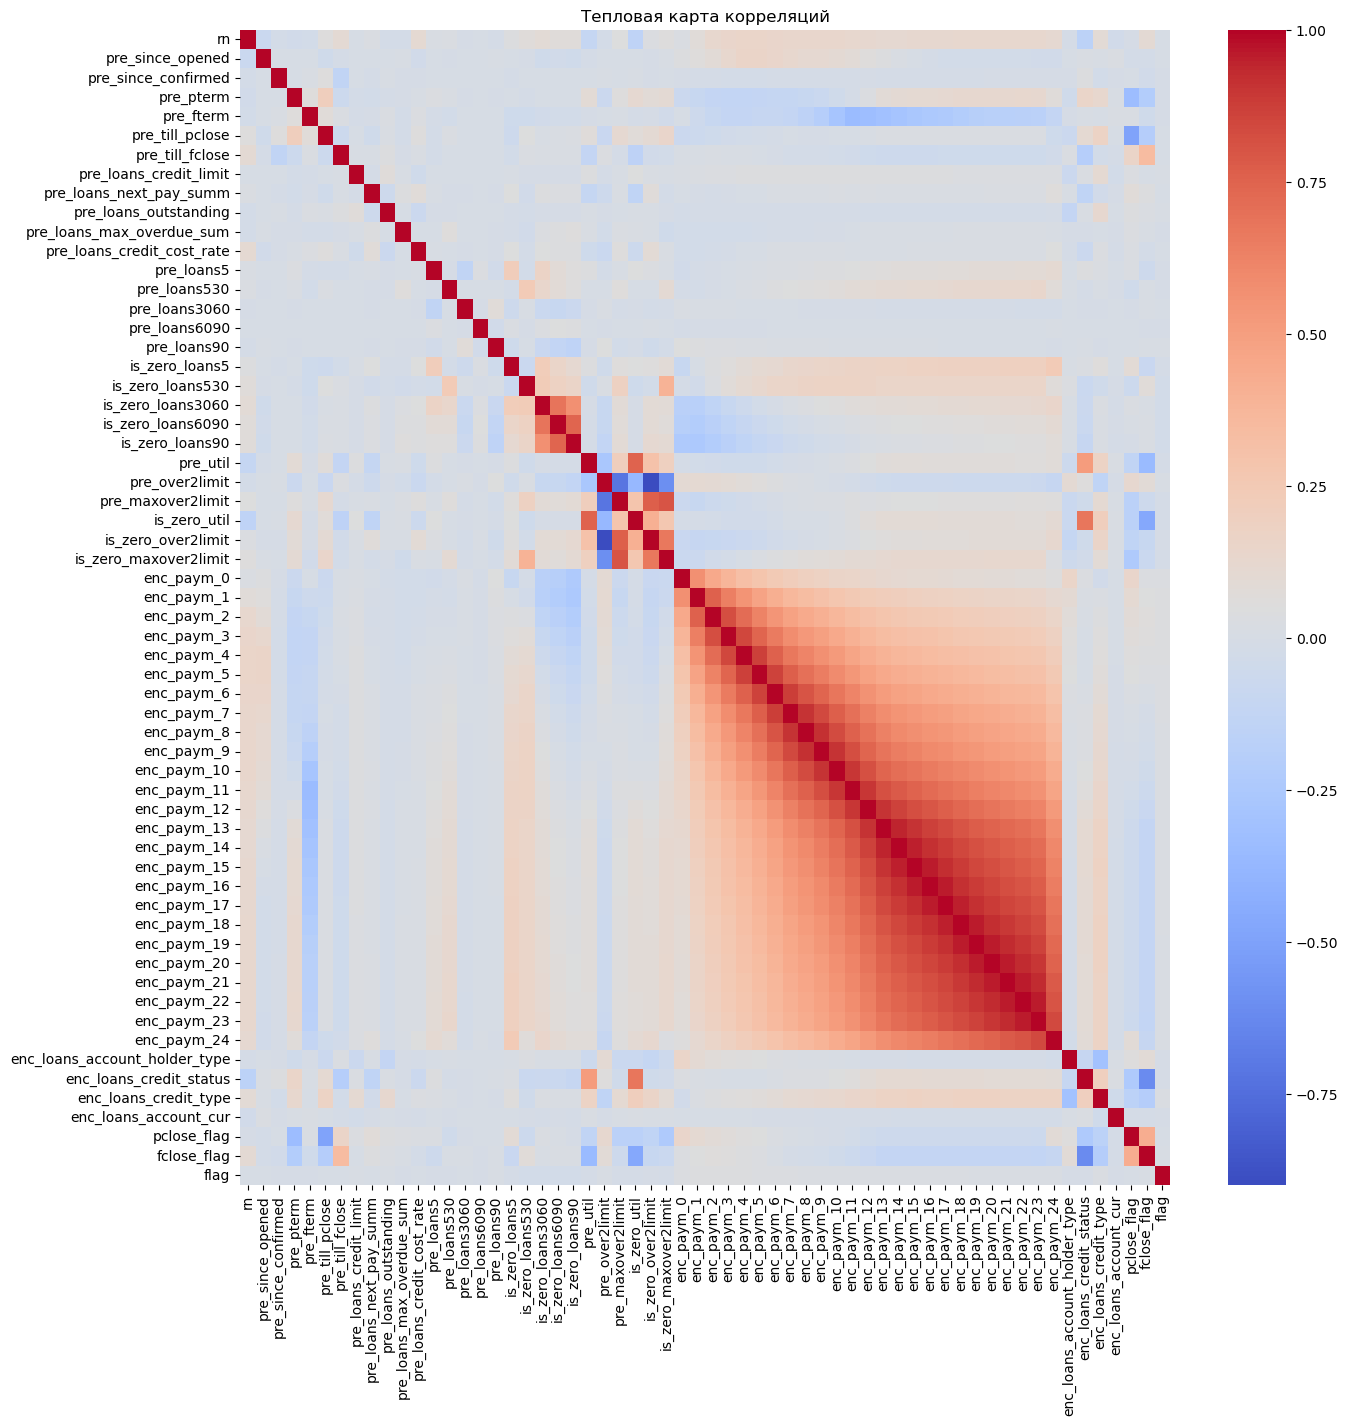

In [26]:
plt.figure(figsize=(15, 15))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')
plt.title('Тепловая карта корреляций')
plt.show()

In [ ]:
# видим довольно высокую корреляцию между признаками enc_paym_{0..N} — статусы ежемесячных платежей за последние N месяцев 
# а также довольно высокую обратную корреляцию между 
# is_zero_over2limit — флаг: отношение текущей просроченной задолженности к кредитному лимиту равно 0
# и pre_over2limit — отношение текущей просроченной задолженности к кредитному лимиту

## Чтение исходных данных + feature engineering (OHE, агрегация, создание фич)

In [3]:
# кодируем категориальные фичи (бинаризованные и закодированные), а также флаги, потому что
# предварительные эксперименты показали, что тогда скор выше

columns_for_ohe = ['pre_since_opened', 'pre_since_confirmed', 'pre_pterm',
'pre_fterm', 'pre_till_pclose', 'pre_till_fclose', 'pre_loans_credit_limit', 'pre_loans_next_pay_summ',
'pre_loans_outstanding', 'pre_loans_total_overdue', 'pre_loans_max_overdue_sum', 'pre_loans_credit_cost_rate', 'pre_loans5',
'pre_loans530', 'pre_loans3060', 'pre_loans6090', 'pre_loans90', 'is_zero_loans5', 'is_zero_loans530', 'is_zero_loans3060',
'is_zero_loans6090', 'is_zero_loans90', 'pre_util', 'pre_over2limit', 'pre_maxover2limit', 'is_zero_util', 'is_zero_over2limit',
'is_zero_maxover2limit', 'enc_paym_0', 'enc_paym_1', 'enc_paym_2', 'enc_paym_3', 'enc_paym_4', 'enc_paym_5', 'enc_paym_6', 'enc_paym_7',
'enc_paym_8', 'enc_paym_9', 'enc_paym_10', 'enc_paym_11', 'enc_paym_12', 'enc_paym_13', 'enc_paym_14', 'enc_paym_15', 'enc_paym_16',
'enc_paym_17', 'enc_paym_18', 'enc_paym_19', 'enc_paym_20', 'enc_paym_21', 'enc_paym_22', 'enc_paym_23', 'enc_paym_24',
'enc_loans_account_holder_type', 'enc_loans_credit_status', 'enc_loans_credit_type', 'enc_loans_account_cur', 'pclose_flag', 'fclose_flag']

In [5]:
def chunks_preprocessing(transactions_frame):
    
    # кодируем категориальные данные
    ohe = OneHotEncoder(sparse_output=False, drop='first', handle_unknown='ignore')
    encoded = ohe.fit_transform(transactions_frame[columns_for_ohe])
    new_features = ohe.get_feature_names_out()
    transactions_frame[new_features] = encoded

    # удаляем исходные колонки
    transactions_frame = transactions_frame.drop(columns_for_ohe, axis=1)
    print('OHE - done!')

    # группируем по id и берем среднее по всем фичам
    # создаем новый признак - длина кредитной истории
    tf1 = transactions_frame.groupby('id', as_index=False)[new_features].mean()
    tf2 = transactions_frame.groupby('id', as_index=False)['rn'].max()  

    transactions_frame = tf1.merge(tf2, on='id')
    
    print('groupby - done!')

    return transactions_frame

In [7]:
def read_parquet_dataset_from_local(path_to_dataset: str, start_from: int = 0,
                                     num_parts_to_read: int = 4, columns=None, verbose=False) -> pd.DataFrame:

    res = []
    dataset_paths = sorted([os.path.join(path_to_dataset, filename) for filename in os.listdir(path_to_dataset)
                              if filename.startswith('train')])
    print(dataset_paths)

    start_from = max(0, start_from)
    chunks = dataset_paths[start_from: start_from + num_parts_to_read]
    if verbose:
        print('Reading chunks:\n')
        for chunk in chunks:
            print(chunk)
    for chunk_path in tqdm.tqdm_notebook(chunks, desc="Reading dataset with pandas"):
        print('chunk_path', chunk_path)
        chunk = pd.read_parquet(chunk_path,columns=columns)
        res.append(chunk)

    return pd.concat(res).reset_index(drop=True)

In [17]:
def prepare_transactions_dataset(path_to_dataset: str, num_parts_to_preprocess_at_once: int = 1, num_parts_total: int=50,
                                 save_to_path=None, verbose: bool=False):

    preprocessed_frames = []

    for step in tqdm.tqdm_notebook(range(0, num_parts_total, num_parts_to_preprocess_at_once),
                                   desc="Transforming transactions data"):

        transactions_frame = read_parquet_dataset_from_local(path_to_dataset, step, num_parts_to_preprocess_at_once,
                                                               verbose=verbose)

        #здесь должен быть препроцессинг данных
        transactions_frame = chunks_preprocessing(transactions_frame)

        preprocessed_frames.append(transactions_frame)
    return pd.concat(preprocessed_frames)

In [ ]:
path='train_data'
data = prepare_transactions_dataset(path, num_parts_to_preprocess_at_once=1, num_parts_total=12,
                                    save_to_path='new_train_data/')

In [20]:
# полученный датасет и его размерность
data

,id,pre_since_opened_1,pre_since_opened_2,pre_since_opened_3,pre_since_opened_4,pre_since_opened_5,pre_since_opened_6,pre_since_opened_7,pre_since_opened_8,pre_since_opened_9,...,pre_loans530_8,pre_loans530_9,pre_loans_total_overdue_1,pre_loans_max_overdue_sum_1,pre_loans3060_1,pre_loans3060_3,pre_loans3060_4,pre_loans6090_1,pre_loans5_10,pre_loans530_17
0,0,0.100000,0.100000,0.100000,0.100000,0.200000,0.000000,0.100000,0.000000,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,0.000000,0.071429,0.000000,0.000000,0.000000,0.000000,0.071429,0.142857,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,0.200000,0.066667,0.000000,0.133333,0.066667,0.200000,0.000000,0.000000,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249995,2499995,0.071429,0.000000,0.000000,0.000000,0.000000,0.000000,0.142857,0.000000,0.0,...,0.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,0.0,0.0
249996,2499996,0.600000,0.000000,0.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,0.0,0.0
249997,2499997,0.071429,0.000000,0.071429,0.000000,0.071429,0.000000,0.000000,0.071429,0.0,...,0.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,0.0,0.0
249998,2499998,0.000000,0.000000,0.142857,0.000000,0.000000,0.142857,0.142857,0.000000,0.0,...,0.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,0.0,0.0


In [21]:
#запишем полученный датасет в csv-файл

#data.to_csv('final_ohe_mean_rn_max_full_df.csv', index=False)

## Сбор финального датасета и train_test_split

In [3]:
# читаем из записанного файла, чтобы не кодировать каждый раз

data = pd.read_csv('final_ohe_mean_rn_max_full_df.csv')
targets = pd.read_csv('train_target.csv')

# объединение датасета с целевой переменной
df = data.merge(targets, on='id')

df = df.drop('id', axis=1)

# размерность финального датасета
df.shape

(3000000, 362)

In [4]:
# посмотрим на баланс классов
df['flag'].value_counts(dropna=False)  

# классы не сбалансированы

flag
0    2893558
1     106442
Name: count, dtype: int64

In [20]:
# разделение дф на обучающую и тестовую выборки со стратификацией, так как дисбаланс классов

X = df.drop('flag', axis=1)
y = df['flag']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

In [6]:
del data
gc.collect()

20

## Логистическая регрессия / Отбор признаков с помощью L1-регуляризации и график важности признаков

In [21]:
# выделим фичи, в которых образовались пропуски при кодировании из-за несовпадения количества категорий в признаках
zero_cols = [col for col in X.columns if X[col].isna().sum() != 0]

# заполним их константой – 0
if zero_cols:
    imputer = SimpleImputer(strategy='constant', fill_value=0)
    X_train[zero_cols] = imputer.fit_transform(X_train[zero_cols])
    X_test[zero_cols] = imputer.fit_transform(X_test[zero_cols])

In [22]:
# Обучение логистической регрессии с L1-регуляризацией для отбора признаков
lr = LogisticRegression(class_weight='balanced', penalty='l1', solver='saga')  # solver='saga' поддерживает L1-регуляризацию для больших дс
lr.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', penalty='l1', solver='saga')

In [23]:
# Оценим качество модели

lr_train_score = roc_auc_score(y_train, lr.predict_proba(X_train)[:,1])
lr_test_score = roc_auc_score(y_test, lr.predict_proba(X_test)[:,1])

print('train_score: ', lr_train_score)
print('test_score: ', lr_test_score)

train_score:  0.7428357682495499
test_score:  0.7405999050415525


In [24]:
# Коэффициенты модели логистической регрессии
coefs_logreg = pd.Series(lr.coef_[0], index=X.columns)

# Отбор признаков на основе коэффициентов
selected_features = coefs_logreg[abs(coefs_logreg) >= 0.03].index.tolist()

# Неважные признаки
useless_features = coefs_logreg[abs(coefs_logreg) < 0.03].index
len(useless_features)

55

In [25]:
selected_coefs_logreg = coefs_logreg.drop(useless_features)

sorted_coefs_logreg = abs(selected_coefs_logreg).sort_values()
sorted_coefs_logreg

pre_since_confirmed_5              0.030149
enc_paym_4_3                       0.031785
pre_loans530_10                    0.031928
pre_fterm_6                        0.032348
enc_paym_21_3                      0.032919
                                     ...   
enc_loans_account_holder_type_6    2.194286
enc_loans_credit_type_5            2.236686
pre_util_17                        2.273106
enc_loans_credit_type_6            2.353428
pre_util_14                        2.473809
Length: 306, dtype: float64

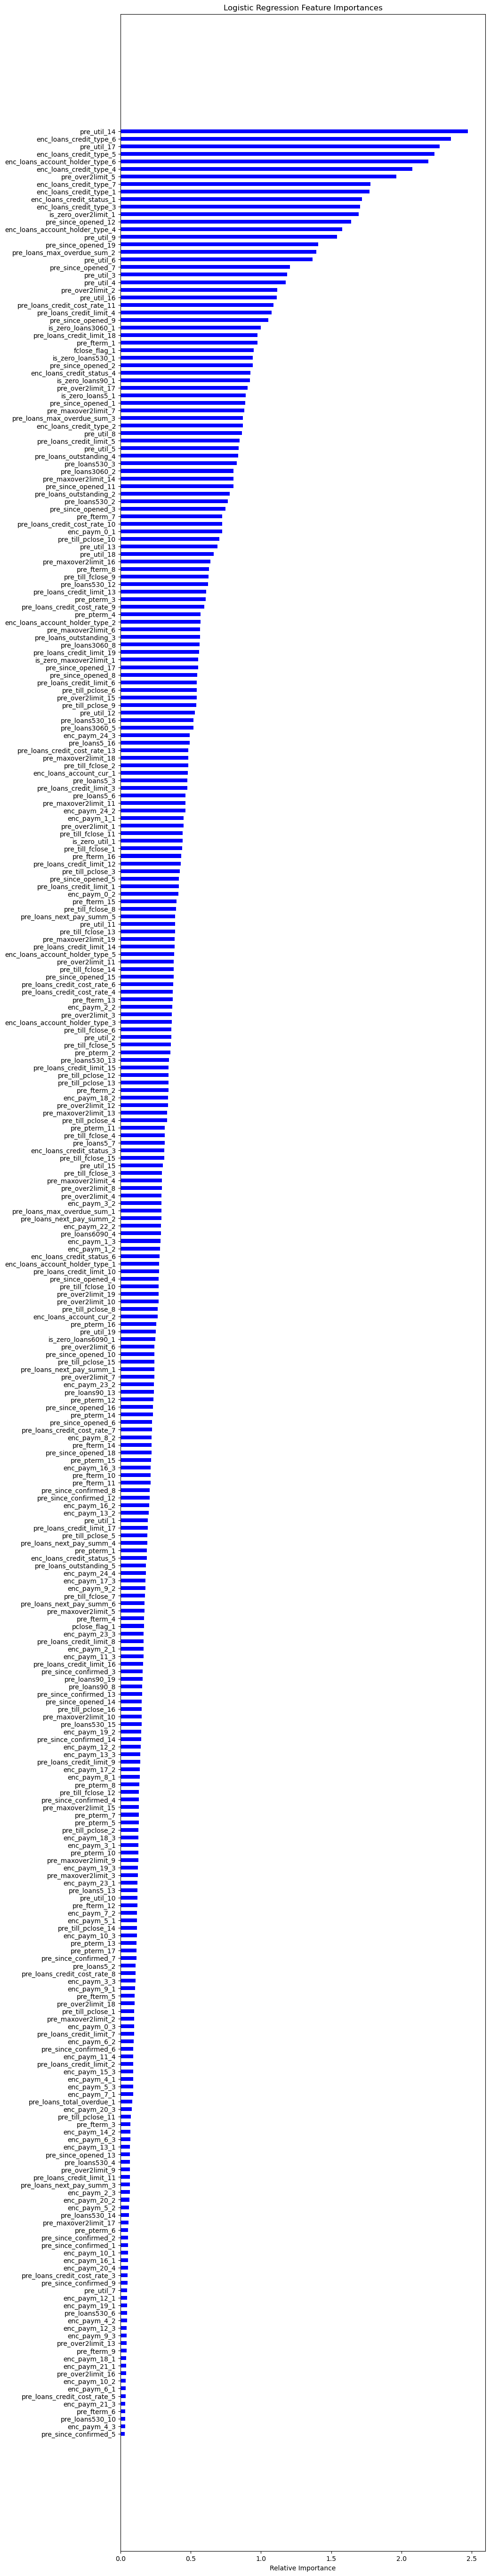

In [36]:
plt.figure(figsize=(10,70))
plt.title('Logistic Regression Feature Importances')
plt.barh(sorted_coefs_logreg.index, abs(sorted_coefs_logreg), height=0.5, color='b')
plt.yticks(sorted_coefs_logreg.index)
plt.xlabel('Relative Importance')
plt.show()

In [ ]:
# самыми важными признаками для модели логистической регрессии является pre_loans530, pre_loans5, pre_loans6090, pre_loans3060, 
# то есть число просрочек за период

## Отбор нужных признаков 

In [8]:
# на всякий случай сохраним выбранные фичи 
# 0.03
selected_features = ['pre_since_opened_1', 'pre_since_opened_2', 'pre_since_opened_3', 'pre_since_opened_4', 'pre_since_opened_5', 'pre_since_opened_6', 'pre_since_opened_7', 'pre_since_opened_8', 'pre_since_opened_9', 'pre_since_opened_10', 'pre_since_opened_11', 'pre_since_opened_12', 'pre_since_opened_13', 'pre_since_opened_14', 'pre_since_opened_15', 'pre_since_opened_16', 'pre_since_opened_17', 'pre_since_opened_18', 'pre_since_opened_19', 'pre_since_confirmed_1', 'pre_since_confirmed_2', 'pre_since_confirmed_3', 'pre_since_confirmed_4', 'pre_since_confirmed_5', 'pre_since_confirmed_6', 'pre_since_confirmed_7', 'pre_since_confirmed_8', 'pre_since_confirmed_9', 'pre_since_confirmed_12', 'pre_since_confirmed_13', 'pre_since_confirmed_14', 'pre_pterm_1', 'pre_pterm_2', 'pre_pterm_3', 'pre_pterm_4', 'pre_pterm_5', 'pre_pterm_6', 'pre_pterm_7', 'pre_pterm_8', 'pre_pterm_10', 'pre_pterm_11', 'pre_pterm_12', 'pre_pterm_13', 'pre_pterm_14', 'pre_pterm_15', 'pre_pterm_16', 'pre_pterm_17', 'pre_fterm_1', 'pre_fterm_2', 'pre_fterm_3', 'pre_fterm_4', 'pre_fterm_5', 'pre_fterm_6', 'pre_fterm_7', 'pre_fterm_8', 'pre_fterm_9', 'pre_fterm_10', 'pre_fterm_11', 'pre_fterm_12', 'pre_fterm_13', 'pre_fterm_14', 'pre_fterm_15', 'pre_fterm_16', 'pre_till_pclose_1', 'pre_till_pclose_2', 'pre_till_pclose_3', 'pre_till_pclose_4', 'pre_till_pclose_5', 'pre_till_pclose_6', 'pre_till_pclose_8', 'pre_till_pclose_9', 'pre_till_pclose_10', 'pre_till_pclose_11', 'pre_till_pclose_12', 'pre_till_pclose_13', 'pre_till_pclose_14', 'pre_till_pclose_15', 'pre_till_pclose_16', 'pre_till_fclose_1', 'pre_till_fclose_2', 'pre_till_fclose_3', 'pre_till_fclose_4', 'pre_till_fclose_5', 'pre_till_fclose_6', 'pre_till_fclose_7', 'pre_till_fclose_8', 'pre_till_fclose_9', 'pre_till_fclose_10', 'pre_till_fclose_11', 'pre_till_fclose_12', 'pre_till_fclose_13', 'pre_till_fclose_14', 'pre_till_fclose_15', 'pre_loans_credit_limit_1', 'pre_loans_credit_limit_2', 'pre_loans_credit_limit_3', 'pre_loans_credit_limit_4', 'pre_loans_credit_limit_5', 'pre_loans_credit_limit_6', 'pre_loans_credit_limit_7', 'pre_loans_credit_limit_8', 'pre_loans_credit_limit_9', 'pre_loans_credit_limit_10', 'pre_loans_credit_limit_11', 'pre_loans_credit_limit_12', 'pre_loans_credit_limit_13', 'pre_loans_credit_limit_14', 'pre_loans_credit_limit_15', 'pre_loans_credit_limit_16', 'pre_loans_credit_limit_17', 'pre_loans_credit_limit_18', 'pre_loans_credit_limit_19', 'pre_loans_next_pay_summ_1', 'pre_loans_next_pay_summ_2', 'pre_loans_next_pay_summ_3', 'pre_loans_next_pay_summ_4', 'pre_loans_next_pay_summ_5', 'pre_loans_next_pay_summ_6', 'pre_loans_outstanding_2', 'pre_loans_outstanding_3', 'pre_loans_outstanding_4', 'pre_loans_outstanding_5', 'pre_loans_max_overdue_sum_2', 'pre_loans_max_overdue_sum_3', 'pre_loans_credit_cost_rate_3', 'pre_loans_credit_cost_rate_4', 'pre_loans_credit_cost_rate_5', 'pre_loans_credit_cost_rate_6', 'pre_loans_credit_cost_rate_7', 'pre_loans_credit_cost_rate_8', 'pre_loans_credit_cost_rate_9', 'pre_loans_credit_cost_rate_10', 'pre_loans_credit_cost_rate_11', 'pre_loans_credit_cost_rate_13', 'pre_loans5_2', 'pre_loans5_3', 'pre_loans5_6', 'pre_loans5_7', 'pre_loans5_13', 'pre_loans5_16', 'pre_loans530_2', 'pre_loans530_3', 'pre_loans530_4', 'pre_loans530_6', 'pre_loans530_10', 'pre_loans530_12', 'pre_loans530_13', 'pre_loans530_14', 'pre_loans530_15', 'pre_loans530_16', 'pre_loans3060_5', 'pre_loans3060_8', 'pre_loans6090_4', 'pre_loans90_13', 'pre_loans90_19', 'is_zero_loans5_1', 'is_zero_loans530_1', 'is_zero_loans3060_1', 'is_zero_loans6090_1', 'is_zero_loans90_1', 'pre_util_1', 'pre_util_2', 'pre_util_3', 'pre_util_4', 'pre_util_5', 'pre_util_6', 'pre_util_7', 'pre_util_8', 'pre_util_9', 'pre_util_10', 'pre_util_11', 'pre_util_12', 'pre_util_13', 'pre_util_14', 'pre_util_15', 'pre_util_16', 'pre_util_17', 'pre_util_18', 'pre_util_19', 'pre_over2limit_1', 'pre_over2limit_2', 'pre_over2limit_3', 'pre_over2limit_4', 'pre_over2limit_5', 'pre_over2limit_6', 'pre_over2limit_7', 'pre_over2limit_8', 'pre_over2limit_9', 'pre_over2limit_10', 'pre_over2limit_11', 'pre_over2limit_12', 'pre_over2limit_13', 'pre_over2limit_15', 'pre_over2limit_16', 'pre_over2limit_17', 'pre_over2limit_18', 'pre_over2limit_19', 'pre_maxover2limit_2', 'pre_maxover2limit_3', 'pre_maxover2limit_4', 'pre_maxover2limit_5', 'pre_maxover2limit_6', 'pre_maxover2limit_7', 'pre_maxover2limit_9', 'pre_maxover2limit_10', 'pre_maxover2limit_11', 'pre_maxover2limit_13', 'pre_maxover2limit_14', 'pre_maxover2limit_15', 'pre_maxover2limit_16', 'pre_maxover2limit_17', 'pre_maxover2limit_18', 'pre_maxover2limit_19', 'is_zero_util_1', 'is_zero_over2limit_1', 'is_zero_maxover2limit_1', 'enc_paym_0_1', 'enc_paym_0_2', 'enc_paym_0_3', 'enc_paym_1_1', 'enc_paym_1_2', 'enc_paym_1_3', 'enc_paym_2_1', 'enc_paym_2_2', 'enc_paym_2_3', 'enc_paym_3_1', 'enc_paym_3_2', 'enc_paym_3_3', 'enc_paym_4_1', 'enc_paym_4_2', 'enc_paym_4_3', 'enc_paym_5_1', 'enc_paym_5_2', 'enc_paym_5_3', 'enc_paym_6_1', 'enc_paym_6_2', 'enc_paym_6_3', 'enc_paym_7_1', 'enc_paym_7_2', 'enc_paym_8_1', 'enc_paym_8_2', 'enc_paym_9_1', 'enc_paym_9_2', 'enc_paym_9_3', 'enc_paym_10_1', 'enc_paym_10_2', 'enc_paym_10_3', 'enc_paym_11_3', 'enc_paym_11_4', 'enc_paym_12_1', 'enc_paym_12_2', 'enc_paym_12_3', 'enc_paym_13_1', 'enc_paym_13_2', 'enc_paym_13_3', 'enc_paym_14_2', 'enc_paym_15_3', 'enc_paym_16_1', 'enc_paym_16_2', 'enc_paym_16_3', 'enc_paym_17_2', 'enc_paym_17_3', 'enc_paym_18_1', 'enc_paym_18_2', 'enc_paym_18_3', 'enc_paym_19_1', 'enc_paym_19_2', 'enc_paym_19_3', 'enc_paym_20_2', 'enc_paym_20_3', 'enc_paym_20_4', 'enc_paym_21_1', 'enc_paym_21_3', 'enc_paym_22_2', 'enc_paym_23_1', 'enc_paym_23_2', 'enc_paym_23_3', 'enc_paym_24_2', 'enc_paym_24_3', 'enc_paym_24_4', 'enc_loans_account_holder_type_1', 'enc_loans_account_holder_type_2', 'enc_loans_account_holder_type_3', 'enc_loans_account_holder_type_4', 'enc_loans_account_holder_type_5', 'enc_loans_account_holder_type_6', 'enc_loans_credit_status_1', 'enc_loans_credit_status_3', 'enc_loans_credit_status_4', 'enc_loans_credit_status_5', 'enc_loans_credit_status_6', 'enc_loans_credit_type_1', 'enc_loans_credit_type_2', 'enc_loans_credit_type_3', 'enc_loans_credit_type_4', 'enc_loans_credit_type_5', 'enc_loans_account_cur_1', 'enc_loans_account_cur_2', 'pclose_flag_1', 'fclose_flag_1', 'pre_loans3060_2', 'pre_loans90_8', 'enc_loans_credit_type_6', 'enc_loans_credit_type_7', 'pre_loans_total_overdue_1', 'pre_loans_max_overdue_sum_1']

In [8]:
# выборки с отобранными признаками

X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

## LightGBM на полных данных

In [7]:
# разделение дф на обучающую и тестовую выборки со стратификацией, так как дисбаланс классов

X = df.drop('flag', axis=1)
y = df['flag']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

In [9]:
# выборки с отобранными признаками

X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

In [9]:
# так как классы несбалансированы 
# scale_pos_weight = (y == 0).sum() / (y == 1).sum()

In [ ]:
# обучение модели на данных с отобранными признаками 

In [12]:
lgbm = lgb.LGBMClassifier(is_unbalance=True) #scale_pos_weight=scale_pos_weight)
lgbm.fit(X_train_selected, y_train)

train_score_lgbm = roc_auc_score(y_train, lgbm.predict_proba(X_train_selected)[:,1])
test_score_lgbm = roc_auc_score(y_test, lgbm.predict_proba(X_test_selected)[:,1])

print('train_score: ', train_score_lgbm)
print('test_score: ', test_score_lgbm)

# train_score:  0.7660143564615717
# test_score:  0.7521971749631752

[LightGBM] [Info] Number of positive: 74509, number of negative: 2025491
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.906136 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 32311
[LightGBM] [Info] Number of data points in the train set: 2100000, number of used features: 306
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.035480 -> initscore=-3.302647
[LightGBM] [Info] Start training from score -3.302647
train_score:  0.7660143564615717
test_score:  0.7521971749631752


In [ ]:
# обучение модели на полном датасете БЕЗ отбора признаков 

In [13]:
lgbm = lgb.LGBMClassifier(is_unbalance=True)
lgbm.fit(X_train, y_train)

train_score_lgbm = roc_auc_score(y_train, lgbm.predict_proba(X_train)[:,1])
test_score_lgbm = roc_auc_score(y_test, lgbm.predict_proba(X_test)[:,1])

print('train_score: ', train_score_lgbm)
print('test_score: ', test_score_lgbm)

# train_score:  0.7669555633119817
# test_score:  0.7533268338422137

[LightGBM] [Info] Number of positive: 74509, number of negative: 2025491
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.200775 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 35276
[LightGBM] [Info] Number of data points in the train set: 2100000, number of used features: 361
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.035480 -> initscore=-3.302647
[LightGBM] [Info] Start training from score -3.302647
train_score:  0.7669555633119817
test_score:  0.7533268338422137


### feature importances lgbmclassifier

In [14]:
lgbm_coefs = pd.Series(lgbm.feature_importances_, index=X.columns).sort_values()
lgbm_coefs

pre_loans530_17                   0
pre_over2limit_8                  0
pre_over2limit_9                  0
pre_over2limit_10                 0
pre_over2limit_11                 0
                                 ..
is_zero_loans5_1                 51
is_zero_loans3060_1              56
pre_loans_credit_cost_rate_11    60
pre_till_pclose_10               66
is_zero_loans530_1               71
Length: 361, dtype: int32

In [15]:
# отберем признаки важность которых > 0 

lgbm_sorted_coefs = lgbm_coefs[lgbm_coefs > 0]
lgbm_sorted_coefs

enc_loans_account_cur_2           1
enc_paym_20_2                     1
pre_loans5_10                     1
pre_loans_credit_limit_8          1
pre_since_confirmed_1             1
                                 ..
is_zero_loans5_1                 51
is_zero_loans3060_1              56
pre_loans_credit_cost_rate_11    60
pre_till_pclose_10               66
is_zero_loans530_1               71
Length: 264, dtype: int32

In [17]:
# отберем признаки важность которых > 0 

lgbm_sorted_coefs2 = lgbm_coefs[lgbm_coefs > 0].apply(lambda x: x / 10)
lgbm_sorted_coefs2

enc_loans_account_cur_2          0.1
enc_paym_20_2                    0.1
pre_loans5_10                    0.1
pre_loans_credit_limit_8         0.1
pre_since_confirmed_1            0.1
                                ... 
is_zero_loans5_1                 5.1
is_zero_loans3060_1              5.6
pre_loans_credit_cost_rate_11    6.0
pre_till_pclose_10               6.6
is_zero_loans530_1               7.1
Length: 264, dtype: float64

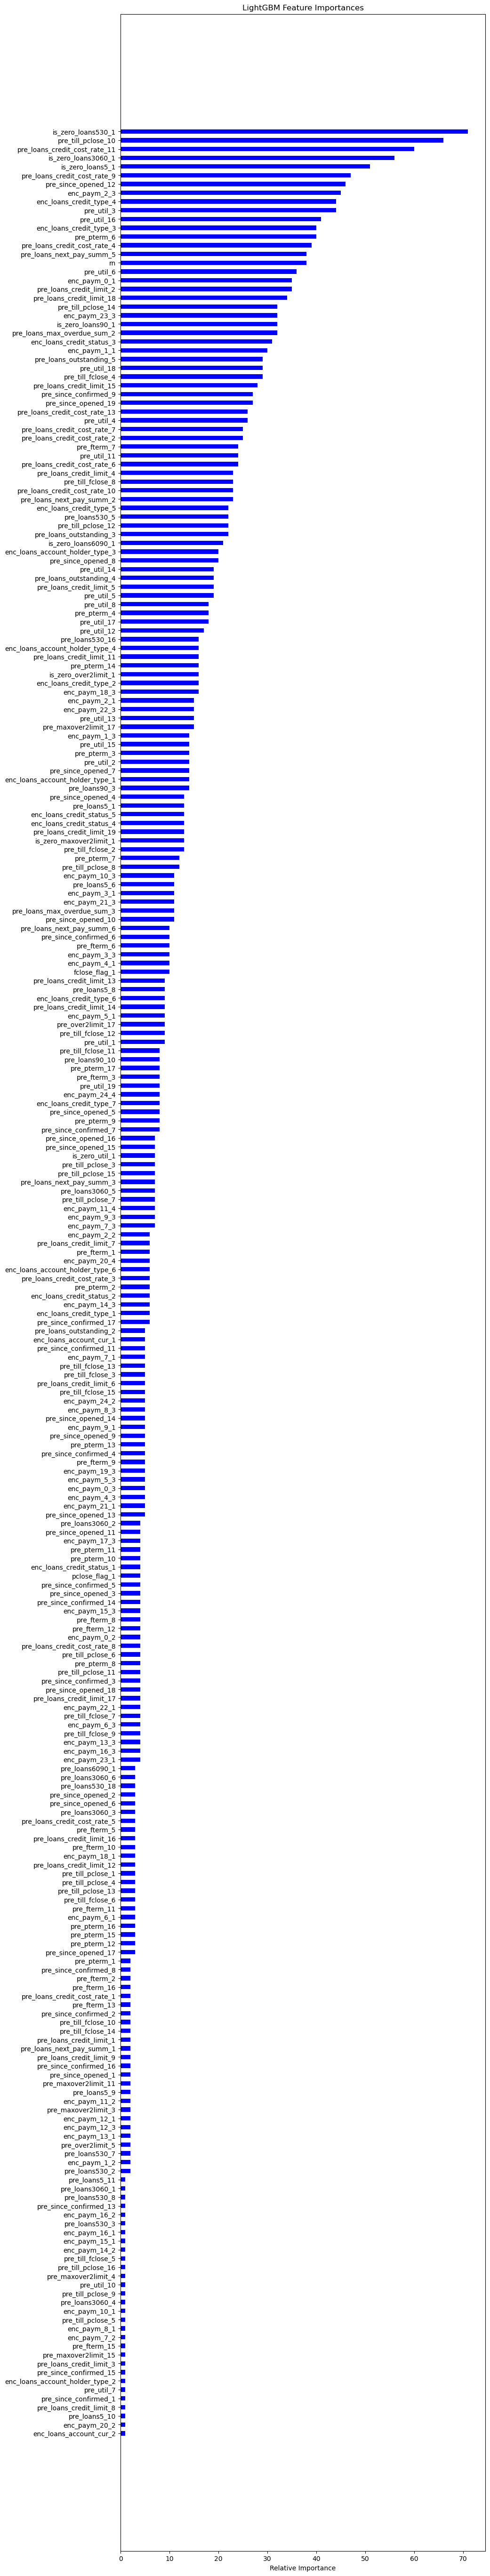

In [19]:
plt.figure(figsize=(10,70))
plt.title('LightGBM Feature Importances')
plt.barh(lgbm_sorted_coefs.index, abs(lgbm_sorted_coefs), height=0.5, color='b')
plt.yticks(lgbm_sorted_coefs.index)
plt.xlabel('Relative Importance')
plt.show()

In [ ]:
# самыми важными признаками для модели LightGBM являются флаги отсутствия просрочек – is_zero_loans*,
# pre_till_pclose — плановое количество дней с даты сбора данных до даты закрытия кредита,
# и pre_loans_credit_cost_rate — полная стоимость кредита

## CatBoost на полных данных

In [26]:
# обучение модели на данных с отобранными признаками 
catb = CatBoostClassifier(auto_class_weights='Balanced', early_stopping_rounds=30, eval_metric='AUC')
catb.fit(X_train_selected, y_train, eval_set=(X_test_selected, y_test), verbose=False, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [27]:
train_score_catb = roc_auc_score(y_train, catb.predict_proba(X_train_selected)[:,1])
test_score_catb = roc_auc_score(y_test, catb.predict_proba(X_test_selected)[:,1])

print('train_score_catb: ', train_score_catb)
print('test_score_catb: ', test_score_catb)


train_score_catb:  0.783255560082533
test_score_catb:  0.7585216000635882


In [ ]:
# обучение модели на данных БЕЗ отбора признаков

In [28]:
X = df.drop('flag', axis=1)
y = df['flag']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

In [29]:
catb2 = CatBoostClassifier(auto_class_weights='Balanced', early_stopping_rounds=30, eval_metric='AUC')
catb2.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=False, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [30]:
train_score_catb2 = roc_auc_score(y_train, catb2.predict_proba(X_train)[:,1])
test_score_catb2 = roc_auc_score(y_test, catb2.predict_proba(X_test)[:,1])

print('train_score_catb: ', train_score_catb2)
print('test_score_catb: ', test_score_catb2)

# train_score_catb:  0.7923738326939178
# test_score_catb:  0.7593988883199232

train_score_catb:  0.7923738326939178
test_score_catb:  0.7593988883199232


### подбор гиперпараметров для модели CatBoost - часть 1

In [34]:
catb2.get_all_params()

{'nan_mode': 'Min',
 'eval_metric': 'Logloss',
 'iterations': 1000,
 'sampling_frequency': 'PerTree',
 'leaf_estimation_method': 'Newton',
 'random_score_type': 'NormalWithModelSizeDecrease',
 'grow_policy': 'SymmetricTree',
 'penalties_coefficient': 1,
 'boosting_type': 'Plain',
 'model_shrink_mode': 'Constant',
 'feature_border_type': 'GreedyLogSum',
 'bayesian_matrix_reg': 0.10000000149011612,
 'eval_fraction': 0,
 'force_unit_auto_pair_weights': False,
 'l2_leaf_reg': 3,
 'random_strength': 1,
 'rsm': 1,
 'boost_from_average': False,
 'model_size_reg': 0.5,
 'pool_metainfo_options': {'tags': {}},
 'subsample': 0.800000011920929,
 'use_best_model': False,
 'class_names': [0, 1],
 'random_seed': 0,
 'depth': 6,
 'posterior_sampling': False,
 'border_count': 254,
 'class_weights': [1, 27.18423080444336],
 'classes_count': 0,
 'auto_class_weights': 'Balanced',
 'sparse_features_conflict_fraction': 0,
 'leaf_estimation_backtracking': 'AnyImprovement',
 'best_model_min_trees': 1,
 'model

In [47]:
?CatBoostClassifier

Init signature:
CatBoostClassifier(
    iterations=None,
    learning_rate=None,
    depth=None,
    l2_leaf_reg=None,
    model_size_reg=None,
    rsm=None,
    loss_function=None,
    border_count=None,
    feature_border_type=None,
    per_float_feature_quantization=None,
    input_borders=None,
    output_borders=None,
    fold_permutation_block=None,
    od_pval=None,
    od_wait=None,
    od_type=None,
    nan_mode=None,
    counter_calc_method=None,
    leaf_estimation_iterations=None,
    leaf_estimation_method=None,
    thread_count=None,
    random_seed=None,
    use_best_model=None,
    best_model_min_trees=None,
    verbose=None,
    silent=None,
    logging_level=None,
    metric_period=None,
    ctr_leaf_count_limit=None,
    store_all_simple_ctr=None,
    max_ctr_complexity=None,
    has_time=None,
    allow_const_label=None,
    target_border=None,
    classes_count=None,
    class_weights=None,
    auto_class_weights=None,
    class_names=None,
    one_hot_max_size=Non

In [20]:
def objective(trial):
    # Зададим широкое пространство значений гиперпараметров для поиска для скорости
    params = {
        'iterations': trial.suggest_int('iterations', 100, 500),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.1, 0.3),
    }

    # Создание и обучение модели
    model = CatBoostClassifier(**params, auto_class_weights='Balanced', early_stopping_rounds=20, eval_metric='AUC')
    model.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=False, plot=True)

    # Предсказания и оценка
    auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])

    # Вывод промежуточных результатов
    trial.report(auc, step=0)
    print(f'Trial {trial.number}, AUC: {auc:.4f}, Parameters: {params}')

    return auc

# Создание и запуск оптимайзера Optuna
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

# Вывод лучших гиперпараметров
print("Best parameters:", study.best_params)
print("Best AUC:", study.best_value)

[I 2024-08-24 10:45:20,561] A new study created in memory with name: no-name-686c66f0-fba0-492e-a68f-257c62c34487


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

[I 2024-08-24 10:47:12,224] Trial 0 finished with value: 0.75659015593128 and parameters: {'iterations': 144, 'learning_rate': 0.19607560627609427}. Best is trial 0 with value: 0.75659015593128.


Trial 0, AUC: 0.7566, Parameters: {'iterations': 144, 'learning_rate': 0.19607560627609427}


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

[I 2024-08-24 10:52:06,211] Trial 1 finished with value: 0.7594143103529063 and parameters: {'iterations': 362, 'learning_rate': 0.10166368707042346}. Best is trial 1 with value: 0.7594143103529063.


Trial 1, AUC: 0.7594, Parameters: {'iterations': 362, 'learning_rate': 0.10166368707042346}


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

[I 2024-08-24 10:56:30,983] Trial 2 finished with value: 0.7596856293995795 and parameters: {'iterations': 426, 'learning_rate': 0.18329046901515925}. Best is trial 2 with value: 0.7596856293995795.


Trial 2, AUC: 0.7597, Parameters: {'iterations': 426, 'learning_rate': 0.18329046901515925}


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

[I 2024-08-24 10:59:13,968] Trial 3 finished with value: 0.757338902191961 and parameters: {'iterations': 402, 'learning_rate': 0.2752162841375218}. Best is trial 2 with value: 0.7596856293995795.


Trial 3, AUC: 0.7573, Parameters: {'iterations': 402, 'learning_rate': 0.2752162841375218}


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

[I 2024-08-24 11:03:05,449] Trial 4 finished with value: 0.759103549074979 and parameters: {'iterations': 269, 'learning_rate': 0.14264770505870217}. Best is trial 2 with value: 0.7596856293995795.


Trial 4, AUC: 0.7591, Parameters: {'iterations': 269, 'learning_rate': 0.14264770505870217}


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

[I 2024-08-24 11:05:05,018] Trial 5 finished with value: 0.7564834754385291 and parameters: {'iterations': 124, 'learning_rate': 0.28961378542803745}. Best is trial 2 with value: 0.7596856293995795.


Trial 5, AUC: 0.7565, Parameters: {'iterations': 124, 'learning_rate': 0.28961378542803745}


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

[I 2024-08-24 11:09:11,196] Trial 6 finished with value: 0.7588485129203871 and parameters: {'iterations': 486, 'learning_rate': 0.2350128012457738}. Best is trial 2 with value: 0.7596856293995795.


Trial 6, AUC: 0.7588, Parameters: {'iterations': 486, 'learning_rate': 0.2350128012457738}


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

[I 2024-08-24 11:12:51,950] Trial 7 finished with value: 0.758506087464173 and parameters: {'iterations': 352, 'learning_rate': 0.2467395914551143}. Best is trial 2 with value: 0.7596856293995795.


Trial 7, AUC: 0.7585, Parameters: {'iterations': 352, 'learning_rate': 0.2467395914551143}


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

[I 2024-08-24 11:16:06,871] Trial 8 finished with value: 0.7564053402008533 and parameters: {'iterations': 213, 'learning_rate': 0.11226427322040944}. Best is trial 2 with value: 0.7596856293995795.


Trial 8, AUC: 0.7564, Parameters: {'iterations': 213, 'learning_rate': 0.11226427322040944}


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

[I 2024-08-24 11:18:00,244] Trial 9 finished with value: 0.7529683850539575 and parameters: {'iterations': 112, 'learning_rate': 0.158209558287298}. Best is trial 2 with value: 0.7596856293995795.


Trial 9, AUC: 0.7530, Parameters: {'iterations': 112, 'learning_rate': 0.158209558287298}


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

[I 2024-08-24 11:23:58,895] Trial 10 finished with value: 0.7600800198939195 and parameters: {'iterations': 486, 'learning_rate': 0.19147806233258693}. Best is trial 10 with value: 0.7600800198939195.


Trial 10, AUC: 0.7601, Parameters: {'iterations': 486, 'learning_rate': 0.19147806233258693}


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

[I 2024-08-24 11:29:33,335] Trial 11 finished with value: 0.7602073500923159 and parameters: {'iterations': 498, 'learning_rate': 0.19070804190247637}. Best is trial 11 with value: 0.7602073500923159.


Trial 11, AUC: 0.7602, Parameters: {'iterations': 498, 'learning_rate': 0.19070804190247637}


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

[I 2024-08-24 11:33:12,194] Trial 12 finished with value: 0.7587972142246487 and parameters: {'iterations': 497, 'learning_rate': 0.20530568270063262}. Best is trial 11 with value: 0.7602073500923159.


Trial 12, AUC: 0.7588, Parameters: {'iterations': 497, 'learning_rate': 0.20530568270063262}


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

[I 2024-08-24 11:39:20,036] Trial 13 finished with value: 0.7604890251696803 and parameters: {'iterations': 451, 'learning_rate': 0.14323005552613507}. Best is trial 13 with value: 0.7604890251696803.


Trial 13, AUC: 0.7605, Parameters: {'iterations': 451, 'learning_rate': 0.14323005552613507}


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

[I 2024-08-24 11:44:58,806] Trial 14 finished with value: 0.760646433235896 and parameters: {'iterations': 425, 'learning_rate': 0.1327203095926308}. Best is trial 14 with value: 0.760646433235896.


Trial 14, AUC: 0.7606, Parameters: {'iterations': 425, 'learning_rate': 0.1327203095926308}


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

[I 2024-08-24 11:50:06,605] Trial 15 finished with value: 0.7604716685576243 and parameters: {'iterations': 410, 'learning_rate': 0.13346233219961434}. Best is trial 14 with value: 0.760646433235896.


Trial 15, AUC: 0.7605, Parameters: {'iterations': 410, 'learning_rate': 0.13346233219961434}


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

[I 2024-08-24 11:54:14,205] Trial 16 finished with value: 0.7590010827081116 and parameters: {'iterations': 298, 'learning_rate': 0.12664868280785024}. Best is trial 14 with value: 0.760646433235896.


Trial 16, AUC: 0.7590, Parameters: {'iterations': 298, 'learning_rate': 0.12664868280785024}


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

[I 2024-08-24 12:00:22,324] Trial 17 finished with value: 0.7604669910115518 and parameters: {'iterations': 450, 'learning_rate': 0.15891728933258006}. Best is trial 14 with value: 0.760646433235896.


Trial 17, AUC: 0.7605, Parameters: {'iterations': 450, 'learning_rate': 0.15891728933258006}


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

[I 2024-08-24 12:05:48,891] Trial 18 finished with value: 0.7600511252158371 and parameters: {'iterations': 365, 'learning_rate': 0.11899477277418599}. Best is trial 14 with value: 0.760646433235896.


Trial 18, AUC: 0.7601, Parameters: {'iterations': 365, 'learning_rate': 0.11899477277418599}


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

[I 2024-08-24 12:09:39,194] Trial 19 finished with value: 0.7584620189314658 and parameters: {'iterations': 248, 'learning_rate': 0.1488195708184092}. Best is trial 14 with value: 0.760646433235896.


Trial 19, AUC: 0.7585, Parameters: {'iterations': 248, 'learning_rate': 0.1488195708184092}
Best parameters: {'iterations': 425, 'learning_rate': 0.1327203095926308}
Best AUC: 0.760646433235896


In [ ]:
# Trial 14 finished with value: 0.760646433235896 and parameters: 
# {'iterations': 425, 'learning_rate': 0.1327203095926308}. Best is trial 14 with value: 0.760646433235896.

# уточним полученные значения - уменьшим learning_rate в 4 раза, чтобы уменьшить возможное переобучение
# соответственно увеличим iterations в 4 раза

# iterations=1700, learning_rate=0.03318

In [21]:
cb = CatBoostClassifier(iterations=1700, learning_rate=0.03318, auto_class_weights='Balanced', early_stopping_rounds=50, eval_metric='AUC')
cb.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=False, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [22]:
cb_train_score = roc_auc_score(y_train, cb.predict_proba(X_train)[:,1])
cb_test_score = roc_auc_score(y_test, cb.predict_proba(X_test)[:,1])

print('train_score_catb: ', cb_train_score)
print('test_score_catb: ', cb_test_score)

train_score_catb:  0.7871078105875565
test_score_catb:  0.7622550033846591


### подбор гиперпараметров для модели CatBoost - часть 2

In [23]:
def objective(trial):
    params = {
        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 4, 20),
        'bagging_temperature': trial.suggest_uniform('bagging_temperature', 0, 1),
    }

    # Создание и обучение модели
    # model = CatBoostClassifier(**params, iterations=1976, learning_rate=0.04957230336860981, auto_class_weights='Balanced', early_stopping_rounds=20, eval_metric='AUC')
    model = CatBoostClassifier(**params, iterations=1700, learning_rate=0.03318, 
                               auto_class_weights='Balanced', early_stopping_rounds=20, eval_metric='AUC')
    model.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=False, plot=True)

    # Предсказания и оценка
    auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])

    # Вывод промежуточных результатов
    trial.report(auc, step=0)
    print(f'Trial {trial.number}, AUC: {auc:.4f}, Parameters: {params}')

    return auc

# Создание и запуск оптумайзера Optuna
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

# Вывод лучших гиперпараметров
print("Best parameters:", study.best_params)
print("Best AUC:", study.best_value)

[I 2024-08-24 13:16:12,948] A new study created in memory with name: no-name-dac489a5-6003-4e10-bdf8-486703f06314


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

[I 2024-08-24 13:38:07,575] Trial 0 finished with value: 0.762312697466597 and parameters: {'l2_leaf_reg': 7.376195278355907, 'bagging_temperature': 0.540149314179523}. Best is trial 0 with value: 0.762312697466597.


Trial 0, AUC: 0.7623, Parameters: {'l2_leaf_reg': 7.376195278355907, 'bagging_temperature': 0.540149314179523}


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

[I 2024-08-24 14:05:17,852] Trial 1 finished with value: 0.7624599880304019 and parameters: {'l2_leaf_reg': 6.125044885257239, 'bagging_temperature': 0.20301667668951284}. Best is trial 1 with value: 0.7624599880304019.


Trial 1, AUC: 0.7625, Parameters: {'l2_leaf_reg': 6.125044885257239, 'bagging_temperature': 0.20301667668951284}


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

[I 2024-08-24 14:31:39,044] Trial 2 finished with value: 0.7627031177926302 and parameters: {'l2_leaf_reg': 14.220982231477636, 'bagging_temperature': 0.6826685949646754}. Best is trial 2 with value: 0.7627031177926302.


Trial 2, AUC: 0.7627, Parameters: {'l2_leaf_reg': 14.220982231477636, 'bagging_temperature': 0.6826685949646754}


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

[I 2024-08-24 14:57:04,771] Trial 3 finished with value: 0.7625199478784784 and parameters: {'l2_leaf_reg': 5.650805494937631, 'bagging_temperature': 0.2547858015659701}. Best is trial 2 with value: 0.7627031177926302.


Trial 3, AUC: 0.7625, Parameters: {'l2_leaf_reg': 5.650805494937631, 'bagging_temperature': 0.2547858015659701}


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

[W 2024-08-24 15:00:56,826] Trial 4 failed with parameters: {'l2_leaf_reg': 16.108826153074098, 'bagging_temperature': 0.31892604205122344} because of the following error: KeyboardInterrupt('').
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.12/site-packages/optuna/study/_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/var/folders/ky/j6pt9_k90334yn9kg0kn9ptw0000gn/T/ipykernel_1695/2518004006.py", line 11, in objective
    model.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=False, plot=True)
  File "/opt/anaconda3/lib/python3.12/site-packages/catboost/core.py", line 5220, in fit
    self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline, use_best_model,
  File "/opt/anaconda3/lib/python3.12/site-packages/catboost/core.py", line 2400, in _fit
    self._train(
  File "/opt/anaconda3/lib/python3.12/site-packages/catboost/core.p

KeyboardInterrupt: 

In [31]:
cb = CatBoostClassifier(iterations=1700, learning_rate=0.03318, l2_leaf_reg=14.220982231477636,
                        bagging_temperature=0.6826685949646754, auto_class_weights='Balanced', 
                        early_stopping_rounds=50, eval_metric='AUC')
cb.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=False, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [32]:
cb_train_score = roc_auc_score(y_train, cb.predict_proba(X_train)[:,1])
cb_test_score = roc_auc_score(y_test, cb.predict_proba(X_test)[:,1])

print('train_score_catb: ', cb_train_score)
print('test_score_catb: ', cb_test_score)

train_score_catb:  0.786149818160872
test_score_catb:  0.7627031177926302


In [ ]:
# с помощью подбора гиперпараметров удалось увеличить скор модели и снизить переобучение

# БЫЛО
# train_score_catb:  0.7923738326939178
# test_score_catb:  0.7593988883199232

# СТАЛО
# train_score_catb:  0.786149818160872
# test_score_catb:  0.7627031177926302

### feature importances catboost

In [34]:
catb_coefs = pd.Series(cb.feature_importances_, index=X.columns).sort_values()
catb_sorted_coefs = catb_coefs[catb_coefs > 0.1]
catb_sorted_coefs

pre_fterm_10                0.100774
pre_since_opened_1          0.101746
pre_till_fclose_12          0.102069
pre_till_pclose_9           0.103369
pre_maxover2limit_3         0.103444
                              ...   
pre_loans_credit_limit_2    3.325045
pre_till_pclose_10          3.366499
is_zero_loans3060_1         4.055574
pre_util_3                  4.702451
is_zero_loans530_1          5.059395
Length: 189, dtype: float64

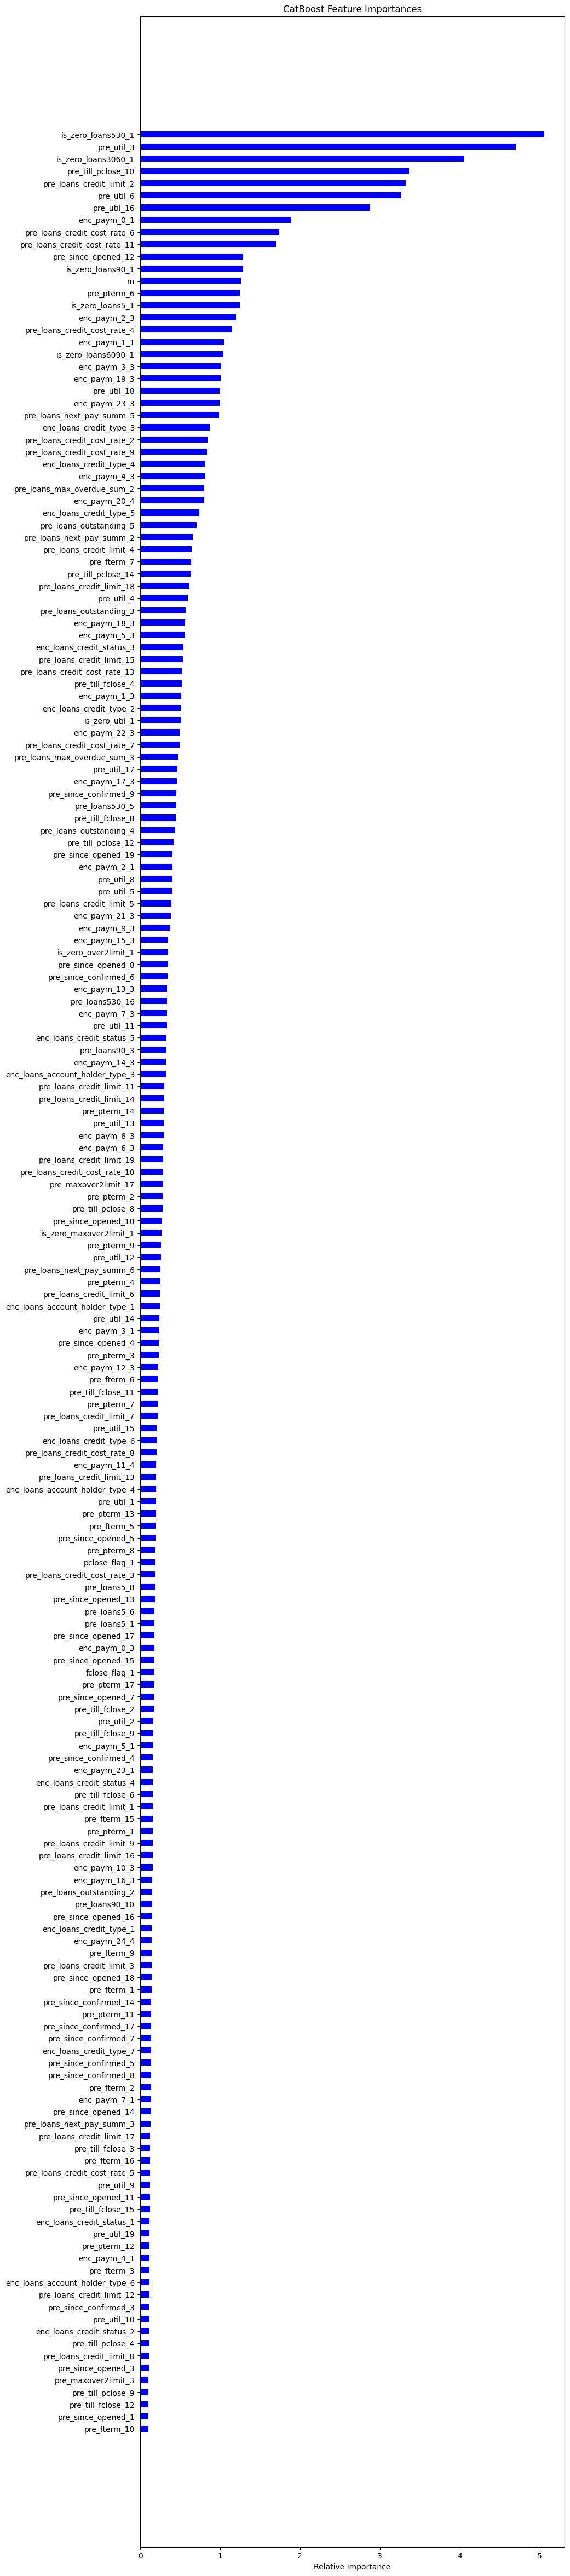

In [35]:
plt.figure(figsize=(10,60))
plt.title('CatBoost Feature Importances')
plt.barh(catb_sorted_coefs.index, abs(catb_sorted_coefs), height=0.5, color='b')
plt.yticks(catb_sorted_coefs.index)
plt.xlabel('Relative Importance')
plt.show()

In [ ]:
# самыми важными признаками для модели CatBoost являются флаги отсутствия просрочек - is_zero_loans*,
# pre_util — отношение оставшейся невыплаченной суммы кредита  к кредитному лимиту,
# pre_loans_credit_limit — кредитный лимит,
# pre_till_pclose — плановое количество дней с даты сбора данных до даты закрытия кредита


## Общий график важности признаков для трех моделей

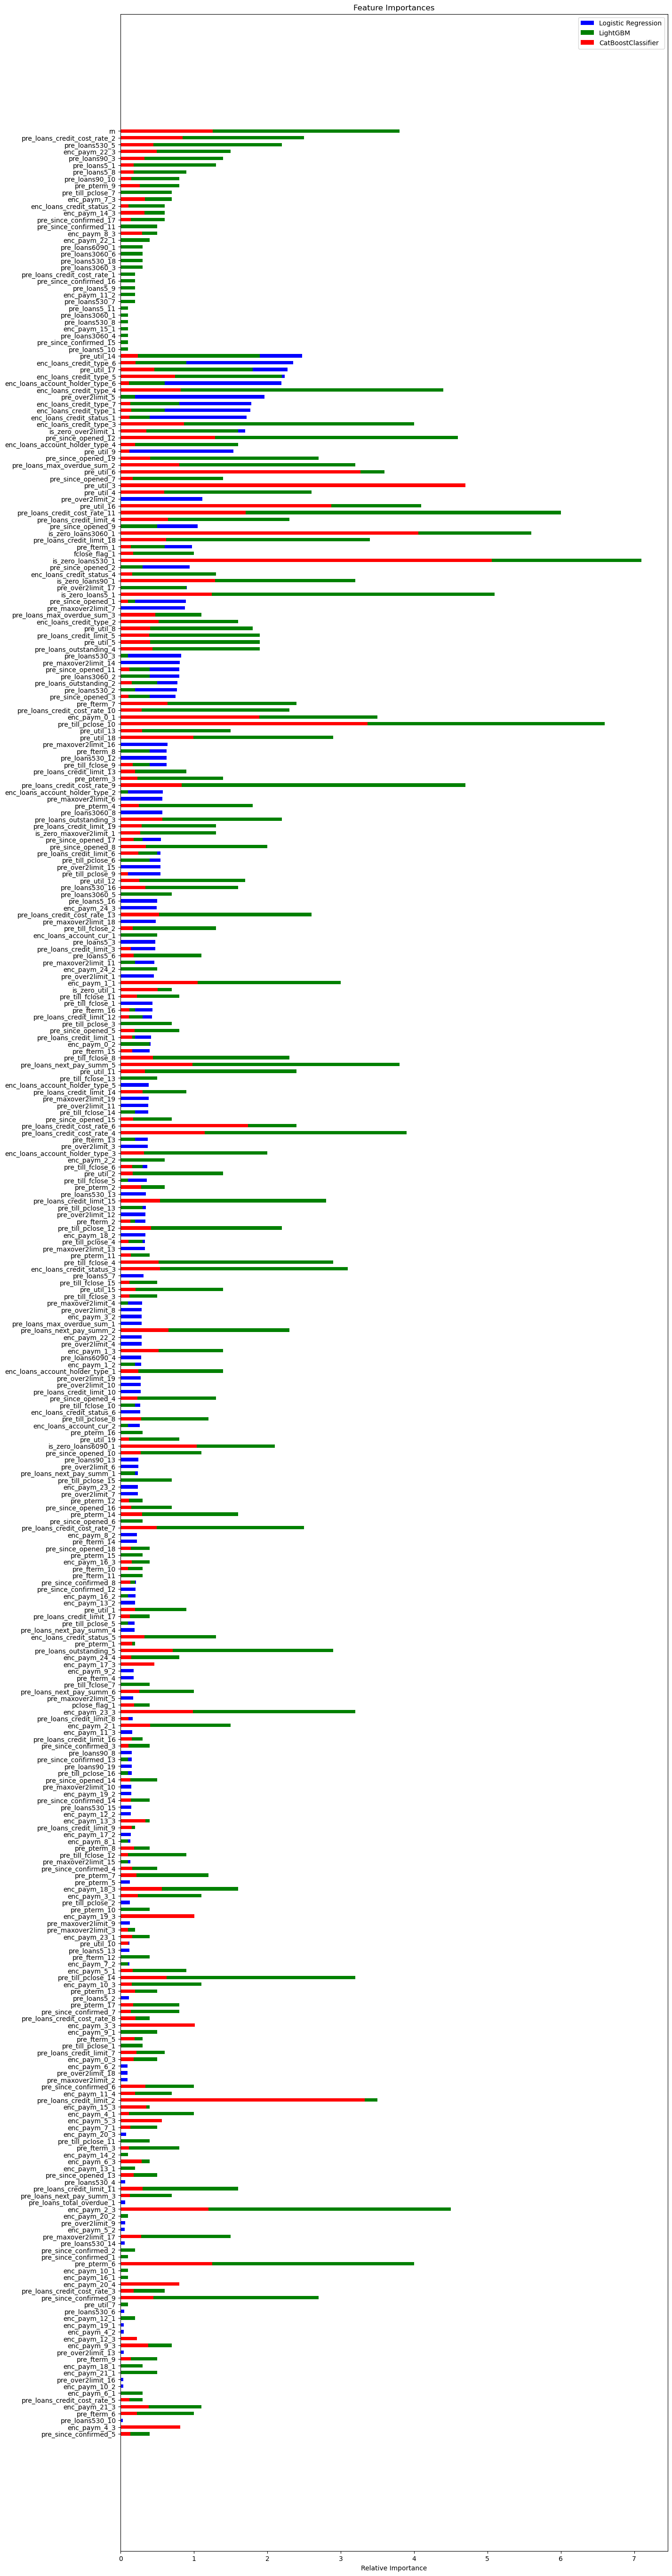

In [36]:
fig, ax = plt.subplots(figsize=(15, 70))

ax.barh(sorted_coefs_logreg.index, abs(sorted_coefs_logreg), height=0.5, color='b')
ax.barh(lgbm_sorted_coefs2.index, abs(lgbm_sorted_coefs2), height=0.5, color='g')
ax.barh(catb_sorted_coefs.index, abs(catb_sorted_coefs), height=0.5, color='r')

plt.title('Feature Importances')
plt.xlabel('Relative Importance')
plt.legend(['Logistic Regression', 'LightGBM', 'CatBoostClassifier'])
plt.show()

## График зависимости roc_auc_score от количества чанков для модели CatBoostClassifier

In [1]:
# список всех признаков после кодирования всех чанков
# нужно для выравнивания 
full_dataset_columns = ['id',  'pre_since_opened_1',  'pre_since_opened_2',  'pre_since_opened_3',  'pre_since_opened_4',  'pre_since_opened_5',  'pre_since_opened_6',  'pre_since_opened_7',  'pre_since_opened_8',  'pre_since_opened_9',  'pre_since_opened_10',  'pre_since_opened_11',  'pre_since_opened_12',  'pre_since_opened_13',  'pre_since_opened_14',  'pre_since_opened_15',  'pre_since_opened_16',  'pre_since_opened_17',  'pre_since_opened_18',  'pre_since_opened_19',  'pre_since_confirmed_1',  'pre_since_confirmed_2',  'pre_since_confirmed_3',  'pre_since_confirmed_4',  'pre_since_confirmed_5',  'pre_since_confirmed_6',  'pre_since_confirmed_7',  'pre_since_confirmed_8',  'pre_since_confirmed_9',  'pre_since_confirmed_10',  'pre_since_confirmed_11',  'pre_since_confirmed_12',  'pre_since_confirmed_13',  'pre_since_confirmed_14',  'pre_since_confirmed_15',  'pre_since_confirmed_16',  'pre_since_confirmed_17',  'pre_pterm_1',  'pre_pterm_2',  'pre_pterm_3',  'pre_pterm_4',  'pre_pterm_5',  'pre_pterm_6',  'pre_pterm_7',  'pre_pterm_8',  'pre_pterm_9',  'pre_pterm_10',  'pre_pterm_11',  'pre_pterm_12',  'pre_pterm_13',  'pre_pterm_14',  'pre_pterm_15',  'pre_pterm_16',  'pre_pterm_17',  'pre_fterm_1',  'pre_fterm_2',  'pre_fterm_3',  'pre_fterm_4',  'pre_fterm_5',  'pre_fterm_6',  'pre_fterm_7',  'pre_fterm_8',  'pre_fterm_9',  'pre_fterm_10',  'pre_fterm_11',  'pre_fterm_12',  'pre_fterm_13',  'pre_fterm_14',  'pre_fterm_15',  'pre_fterm_16',  'pre_till_pclose_1',  'pre_till_pclose_2',  'pre_till_pclose_3',  'pre_till_pclose_4',  'pre_till_pclose_5',  'pre_till_pclose_6',  'pre_till_pclose_7',  'pre_till_pclose_8',  'pre_till_pclose_9',  'pre_till_pclose_10',  'pre_till_pclose_11',  'pre_till_pclose_12',  'pre_till_pclose_13',  'pre_till_pclose_14',  'pre_till_pclose_15',  'pre_till_pclose_16',  'pre_till_fclose_1',  'pre_till_fclose_2',  'pre_till_fclose_3',  'pre_till_fclose_4',  'pre_till_fclose_5',  'pre_till_fclose_6',  'pre_till_fclose_7',  'pre_till_fclose_8',  'pre_till_fclose_9',  'pre_till_fclose_10',  'pre_till_fclose_11',  'pre_till_fclose_12',  'pre_till_fclose_13',  'pre_till_fclose_14',  'pre_till_fclose_15',  'pre_loans_credit_limit_1',  'pre_loans_credit_limit_2',  'pre_loans_credit_limit_3',  'pre_loans_credit_limit_4',  'pre_loans_credit_limit_5',  'pre_loans_credit_limit_6',  'pre_loans_credit_limit_7',  'pre_loans_credit_limit_8',  'pre_loans_credit_limit_9',  'pre_loans_credit_limit_10',  'pre_loans_credit_limit_11',  'pre_loans_credit_limit_12',  'pre_loans_credit_limit_13',  'pre_loans_credit_limit_14',  'pre_loans_credit_limit_15',  'pre_loans_credit_limit_16',  'pre_loans_credit_limit_17',  'pre_loans_credit_limit_18',  'pre_loans_credit_limit_19',  'pre_loans_next_pay_summ_1',  'pre_loans_next_pay_summ_2',  'pre_loans_next_pay_summ_3',  'pre_loans_next_pay_summ_4',  'pre_loans_next_pay_summ_5',  'pre_loans_next_pay_summ_6',  'pre_loans_outstanding_2',  'pre_loans_outstanding_3',  'pre_loans_outstanding_4',  'pre_loans_outstanding_5',  'pre_loans_max_overdue_sum_2',  'pre_loans_max_overdue_sum_3',  'pre_loans_credit_cost_rate_1',  'pre_loans_credit_cost_rate_2',  'pre_loans_credit_cost_rate_3',  'pre_loans_credit_cost_rate_4',  'pre_loans_credit_cost_rate_5',  'pre_loans_credit_cost_rate_6',  'pre_loans_credit_cost_rate_7',  'pre_loans_credit_cost_rate_8',  'pre_loans_credit_cost_rate_9',  'pre_loans_credit_cost_rate_10',  'pre_loans_credit_cost_rate_11',  'pre_loans_credit_cost_rate_12',  'pre_loans_credit_cost_rate_13',  'pre_loans5_2',  'pre_loans5_3',  'pre_loans5_5',  'pre_loans5_6',  'pre_loans5_7',  'pre_loans5_13',  'pre_loans5_16',  'pre_loans530_1',  'pre_loans530_2',  'pre_loans530_3',  'pre_loans530_4',  'pre_loans530_6',  'pre_loans530_7',  'pre_loans530_10',  'pre_loans530_11',  'pre_loans530_12',  'pre_loans530_13',  'pre_loans530_14',  'pre_loans530_15',  'pre_loans530_16',  'pre_loans530_18',  'pre_loans3060_5',  'pre_loans3060_7',  'pre_loans3060_8',  'pre_loans3060_9',  'pre_loans6090_2',  'pre_loans6090_4',  'pre_loans90_13',  'pre_loans90_14',  'pre_loans90_19',  'is_zero_loans5_1',  'is_zero_loans530_1',  'is_zero_loans3060_1',  'is_zero_loans6090_1',  'is_zero_loans90_1',  'pre_util_1',  'pre_util_2',  'pre_util_3',  'pre_util_4',  'pre_util_5',  'pre_util_6',  'pre_util_7',  'pre_util_8',  'pre_util_9',  'pre_util_10',  'pre_util_11',  'pre_util_12',  'pre_util_13',  'pre_util_14',  'pre_util_15',  'pre_util_16',  'pre_util_17',  'pre_util_18',  'pre_util_19',  'pre_over2limit_1',  'pre_over2limit_2',  'pre_over2limit_3',  'pre_over2limit_4',  'pre_over2limit_5',  'pre_over2limit_6',  'pre_over2limit_7',  'pre_over2limit_8',  'pre_over2limit_9',  'pre_over2limit_10',  'pre_over2limit_11',  'pre_over2limit_12',  'pre_over2limit_13',  'pre_over2limit_14',  'pre_over2limit_15',  'pre_over2limit_16',  'pre_over2limit_17',  'pre_over2limit_18',  'pre_over2limit_19',  'pre_maxover2limit_1',  'pre_maxover2limit_2',  'pre_maxover2limit_3',  'pre_maxover2limit_4',  'pre_maxover2limit_5',  'pre_maxover2limit_6',  'pre_maxover2limit_7',  'pre_maxover2limit_8',  'pre_maxover2limit_9',  'pre_maxover2limit_10',  'pre_maxover2limit_11',  'pre_maxover2limit_12',  'pre_maxover2limit_13',  'pre_maxover2limit_14',  'pre_maxover2limit_15',  'pre_maxover2limit_16',  'pre_maxover2limit_17',  'pre_maxover2limit_18',  'pre_maxover2limit_19',  'is_zero_util_1',  'is_zero_over2limit_1',  'is_zero_maxover2limit_1',  'enc_paym_0_1',  'enc_paym_0_2',  'enc_paym_0_3',  'enc_paym_1_1',  'enc_paym_1_2',  'enc_paym_1_3',  'enc_paym_2_1',  'enc_paym_2_2',  'enc_paym_2_3',  'enc_paym_3_1',  'enc_paym_3_2',  'enc_paym_3_3',  'enc_paym_4_1',  'enc_paym_4_2',  'enc_paym_4_3',  'enc_paym_5_1',  'enc_paym_5_2',  'enc_paym_5_3',  'enc_paym_6_1',  'enc_paym_6_2',  'enc_paym_6_3',  'enc_paym_7_1',  'enc_paym_7_2',  'enc_paym_7_3',  'enc_paym_8_1',  'enc_paym_8_2',  'enc_paym_8_3',  'enc_paym_9_1',  'enc_paym_9_2',  'enc_paym_9_3',  'enc_paym_10_1',  'enc_paym_10_2',  'enc_paym_10_3',  'enc_paym_11_2',  'enc_paym_11_3',  'enc_paym_11_4',  'enc_paym_12_1',  'enc_paym_12_2',  'enc_paym_12_3',  'enc_paym_13_1',  'enc_paym_13_2',  'enc_paym_13_3',  'enc_paym_14_1',  'enc_paym_14_2',  'enc_paym_14_3',  'enc_paym_15_1',  'enc_paym_15_2',  'enc_paym_15_3',  'enc_paym_16_1',  'enc_paym_16_2',  'enc_paym_16_3',  'enc_paym_17_1',  'enc_paym_17_2',  'enc_paym_17_3',  'enc_paym_18_1',  'enc_paym_18_2',  'enc_paym_18_3',  'enc_paym_19_1',  'enc_paym_19_2',  'enc_paym_19_3',  'enc_paym_20_2',  'enc_paym_20_3',  'enc_paym_20_4',  'enc_paym_21_1',  'enc_paym_21_2',  'enc_paym_21_3',  'enc_paym_22_1',  'enc_paym_22_2',  'enc_paym_22_3',  'enc_paym_23_1',  'enc_paym_23_2',  'enc_paym_23_3',  'enc_paym_24_2',  'enc_paym_24_3',  'enc_paym_24_4',  'enc_loans_account_holder_type_1',  'enc_loans_account_holder_type_2',  'enc_loans_account_holder_type_3',  'enc_loans_account_holder_type_4',  'enc_loans_account_holder_type_5',  'enc_loans_account_holder_type_6',  'enc_loans_credit_status_1',  'enc_loans_credit_status_2',  'enc_loans_credit_status_3',  'enc_loans_credit_status_4',  'enc_loans_credit_status_5',  'enc_loans_credit_status_6',  'enc_loans_credit_type_1',  'enc_loans_credit_type_2',  'enc_loans_credit_type_3',  'enc_loans_credit_type_4',  'enc_loans_credit_type_5',  'enc_loans_account_cur_1',  'enc_loans_account_cur_2',  'enc_loans_account_cur_3',  'pclose_flag_1',  'fclose_flag_1',  'rn',  'pre_loans5_1',  'pre_loans530_19',  'pre_loans3060_2',  'pre_loans6090_3',  'pre_loans90_8',  'pre_loans5_8',  'pre_loans5_9',  'pre_loans5_11',  'pre_loans530_5',  'pre_loans3060_6',  'pre_loans90_3',  'pre_loans90_10',  'enc_loans_credit_type_6',  'enc_loans_credit_type_7',  'pre_loans530_8',  'pre_loans530_9',  'pre_loans_total_overdue_1',  'pre_loans_max_overdue_sum_1',  'pre_loans3060_1',  'pre_loans3060_3',  'pre_loans3060_4',  'pre_loans6090_1',  'pre_loans5_10',  'pre_loans530_17']

In [5]:
targets = pd.read_csv('train_target.csv')

folder_path = 'new_train_data'

In [7]:
scores = []
step = 0
best_model = None
best_test_score = 0
combined_transaction_frame = pd.DataFrame(columns=full_dataset_columns)

files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]

# чтение заранее подготовленных чанков с OHE и группировкой по id для ускорения
for file in files:
    file_path = os.path.join(folder_path, file)
    transactions_frame = pd.read_csv(file_path)

    new_features = transactions_frame.columns.tolist()
    
    # выравнивание признаков, так как после OHE каждого чанка 
    # из-за несовпадения количества категорий, между чанками различается количество и порядок признаков 
    missing_in_initial = [feat for feat in new_features if feat not in full_dataset_columns]
    missing_in_new = [feat for feat in full_dataset_columns if feat not in new_features]
    
    for feat in missing_in_initial:
        transactions_frame[feat] = None
    
    for feat in missing_in_new:
        transactions_frame[feat] = None
    
    transactions_frame = transactions_frame[full_dataset_columns]

    # объединение датасета с целевой переменной
    transactions_frame = transactions_frame.merge(targets, on='id')       
    
    transactions_frame = transactions_frame.drop('id', axis=1)

    combined_transaction_frame = pd.concat([combined_transaction_frame, transactions_frame])

    # разделение дф на обучающую и тестовую выборки со стратификацией, так как дисбаланс классов
    X = combined_transaction_frame.drop('flag', axis=1)
    y = combined_transaction_frame['flag']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

    model = CatBoostClassifier(auto_class_weights='Balanced', verbose=False, learning_rate=0.03, penalties_coefficient=2.5)
    model.fit(X_train, y_train)

    train_score = roc_auc_score(y_train, model.predict_proba(X_train)[:,1])
    test_score = roc_auc_score(y_test, model.predict_proba(X_test)[:,1])
    print('train_score_lgbm: ', train_score)
    print('test_score_lgbm: ', test_score, '\n')

    if test_score > best_test_score:
        best_test_score = test_score
        best_model = model

    scores.append([step, train_score, test_score])
    step += 1


train_score_lgbm:  0.8883690238445419
test_score_lgbm:  0.7605783953431507 

train_score_lgbm:  0.8299556165202874
test_score_lgbm:  0.7557585660047026 

train_score_lgbm:  0.8081005229254948
test_score_lgbm:  0.7578984434746463 

train_score_lgbm:  0.7930146873279431
test_score_lgbm:  0.7573438905029796 

train_score_lgbm:  0.7849556599177809
test_score_lgbm:  0.7556434169230606 

train_score_lgbm:  0.7807296516793496
test_score_lgbm:  0.7567373487709343 

train_score_lgbm:  0.7767619131755374
test_score_lgbm:  0.7537674412711046 

train_score_lgbm:  0.7721929931112352
test_score_lgbm:  0.7550767254885222 

train_score_lgbm:  0.7730659465020314
test_score_lgbm:  0.7553442549807075 

train_score_lgbm:  0.7719124304254568
test_score_lgbm:  0.7581848232563443 

train_score_lgbm:  0.772083817149963
test_score_lgbm:  0.759263629125132 

train_score_lgbm:  0.7716685146930704
test_score_lgbm:  0.75652202057329 



In [10]:
df_scores = pd.DataFrame(scores, columns=['step', 'train_score', 'test_score'])
df_scores

,step,train_score,test_score
0,0,0.888369,0.760578
1,1,0.829956,0.755759
2,2,0.808101,0.757898
3,3,0.793015,0.757344
4,4,0.784956,0.755643
5,5,0.780730,0.756737
6,6,0.776762,0.753767
7,7,0.772193,0.755077
8,8,0.773066,0.755344
9,9,0.771912,0.758185


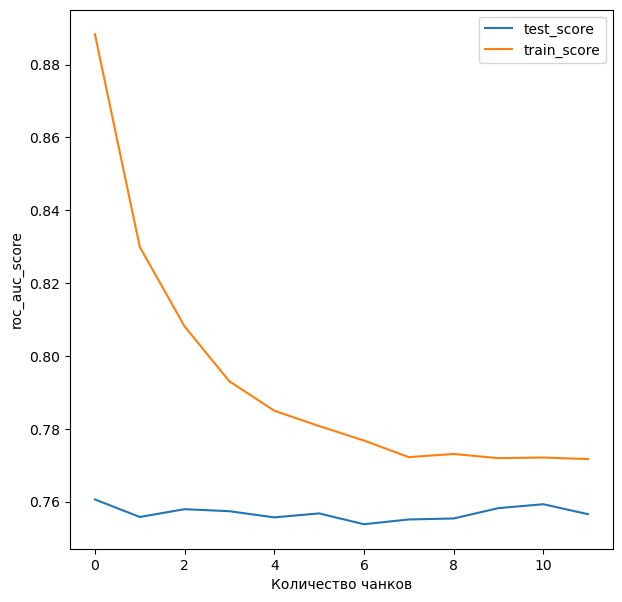

In [12]:
plt.figure(figsize=(7,7))
plt.plot(df_scores['step'], df_scores['test_score'])
plt.plot(df_scores['step'], df_scores['train_score'])
plt.legend(['test_score', 'train_score'])
plt.xlabel('Количество чанков')
plt.ylabel('roc_auc_score')
plt.show()

In [ ]:
# при увеличении количества данных переобучение снижается, скор немного увеличивается, 
# что говорит о том, что зависимости в данных от чанка к чанку сохраняются